In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from flareTools import id_segments

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

path14 = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec14/'
path15 = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec15/'

Compare flare pipeline results with Lupita's working picking out flares by eye from GJ1243.

In [2]:
tic_gaia_table_14 = pd.read_csv('ticGAIA14.csv')
tic_gaia_table_15 = pd.read_csv('ticGAIA15.csv')
param_table_14 = pd.read_csv('14_param_out.csv')
param_table_15 = pd.read_csv('15_param_out.csv')
flare_table_14 = pd.read_csv('14_flare_out.csv')
flare_table_15 = pd.read_csv('15_flare_out.csv')

In [3]:
flare_gaia_table_14 = pd.merge(tic_gaia_table_14, flare_table_14, on='TIC')
flare_gaia_table_15 = pd.merge(tic_gaia_table_15, flare_table_15, on='TIC')
print(len(flare_gaia_table_14), len(flare_gaia_table_15))

5082 3147


In [4]:
GJ1243_TIC = 273589987
filename14 = param_table_14[param_table_14['TIC'] == GJ1243_TIC]['file'].values[0]
print(filename14)
filename15 = param_table_15[param_table_15['TIC'] == GJ1243_TIC]['file'].values[0]
print(filename15)

df14 = flare_gaia_table_14
df15 = flare_gaia_table_15

tess2019198215352-s0014-0000000273589987-0150-s_lc.fits
tess2019226182529-s0015-0000000273589987-0151-s_lc.fits


In [5]:
# Flare events found by eye by Lupita
fbeye14 = pd.read_csv('gj1243_tess14.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]
t_starts = fbeye14.loc[:,'t_start'].values
t_stops = fbeye14.loc[:,'t_stop'].values
flux_peak = fbeye14.loc[:,'Flux_peak'].values
ed_eye = fbeye14.loc[:,'Equiv_Dur'].values
sn_eye = fbeye14.loc[:,'S/N'].values

fbeye15 = pd.read_csv('gj1243_tess15.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]
t_starts = np.append(t_starts, fbeye15.loc[:,'t_start'].values)
t_stops = np.append(t_stops, fbeye15.loc[:,'t_stop'].values)
flux_peak = np.append(flux_peak, fbeye15.loc[:,'Flux_peak'].values)
ed_eye = np.append(ed_eye, fbeye15.loc[:,'Equiv_Dur'].values)
sn_eye = np.append(sn_eye, fbeye15.loc[:,'S/N'].values)

Text(0, 0.5, 'Normalized Flux')

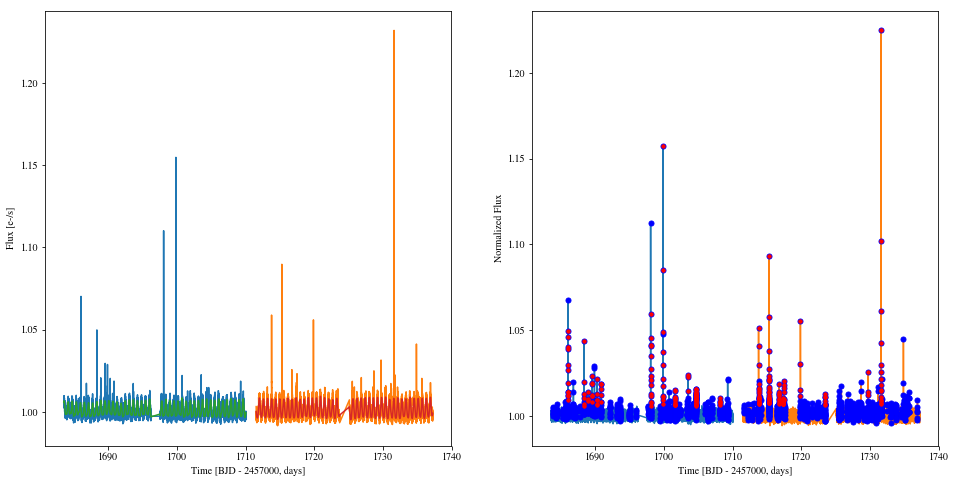

In [6]:
dt_limit = 12/24 # 12 hours
trim = 4/24 # 4 hours

tstart = df14[df14['file'] == filename14]['t0'].values
tstop = df14[df14['file'] == filename14]['t1'].values
tstart = np.append(tstart, df15[df15['file'] == filename15]['t0'].values)
tstop = np.append(tstop, df15[df15['file'] == filename15]['t1'].values)

fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)

with fits.open(path14+filename14, mode='readonly') as hdulist:
        tess_bjd14 = hdulist[1].data['TIME']
        pdcsap_flux14 = hdulist[1].data['PDCSAP_FLUX']
        pdcsap_flux_error14 = hdulist[1].data['PDCSAP_FLUX_ERR']
        quality14 = hdulist[1].data['QUALITY']
        
smo14, var14 = np.loadtxt(path14+filename14+'.gp')
ok_cut14 = (quality14 == 0) & (~np.isnan(tess_bjd14)) & (~np.isnan(pdcsap_flux14)) & (~np.isnan(pdcsap_flux_error14))

istart, istop = id_segments(tess_bjd14[ok_cut14], dt_limit, dt_trim=trim)

time_c14 = np.array([])
flux_c14 = np.array([])
error_c14 = np.array([])

for seg_idx in range(len(istart)):
    tess_bjd_seg14 = tess_bjd14[ok_cut14][istart[seg_idx]:istop[seg_idx]]
    pdcsap_flux_seg14 = pdcsap_flux14[ok_cut14][istart[seg_idx]:istop[seg_idx]]
    pdcsap_flux_error_seg14 = pdcsap_flux_error14[ok_cut14][istart[seg_idx]:istop[seg_idx]]

    time_c14 = np.concatenate((time_c14, tess_bjd_seg14), axis=0)
    flux_c14 = np.concatenate((flux_c14, pdcsap_flux_seg14), axis=0)
    error_c14 = np.concatenate((error_c14, pdcsap_flux_error_seg14), axis=0)

median14 = np.nanmedian(flux_c14)
# Oops, the median column in the flare table wasnt set right
df14['med'].values[:] = median14

with fits.open(path15+filename15, mode='readonly') as hdulist:
        tess_bjd15 = hdulist[1].data['TIME']
        pdcsap_flux15 = hdulist[1].data['PDCSAP_FLUX']
        pdcsap_flux_error15 = hdulist[1].data['PDCSAP_FLUX_ERR']
        quality15 = hdulist[1].data['QUALITY']
    
smo15, var15 = np.loadtxt(path15+filename15+'.gp')
ok_cut15 = (quality15 == 0) & (~np.isnan(tess_bjd15)) & (~np.isnan(pdcsap_flux15)) & (~np.isnan(pdcsap_flux_error15))

dt_limit = 12/24 # 12 hours
trim = 4/24 # 4 hours
istart, istop = id_segments(tess_bjd15[ok_cut15], dt_limit, dt_trim=trim)

time_c15 = np.array([])
flux_c15 = np.array([])
error_c15 = np.array([])

for seg_idx in range(len(istart)):
    tess_bjd_seg15 = tess_bjd15[ok_cut15][istart[seg_idx]:istop[seg_idx]]
    pdcsap_flux_seg15 = pdcsap_flux15[ok_cut15][istart[seg_idx]:istop[seg_idx]]
    pdcsap_flux_error_seg15 = pdcsap_flux_error15[ok_cut15][istart[seg_idx]:istop[seg_idx]]

    time_c15 = np.concatenate((time_c15, tess_bjd_seg15), axis=0)
    flux_c15 = np.concatenate((flux_c15, pdcsap_flux_seg15), axis=0)
    error_c15 = np.concatenate((error_c15, pdcsap_flux_error_seg15), axis=0)
    
median15 = np.nanmedian(flux_c15)
med_flux_err = np.nanmedian(error_c15)/median15
df15['med'].values[:] = median15

axes[0].plot(time_c14, flux_c14/median14)
axes[0].plot(time_c15, flux_c15/median15)
axes[0].plot(time_c14, smo14)
axes[0].plot(time_c15, smo15)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')

x14 = time_c14
y14 = flux_c14/median14 - smo14 + 1
axes[1].plot(x14, y14)

x15 = time_c15
y15 = flux_c15/median15 - smo15 + 1
axes[1].plot(x15, y15)

for idx in range(len((t_starts))):
    indices14 = np.where((x14 >= t_starts[idx]) & (x14 <= t_stops[idx]))[0]
    axes[1].plot(x14[indices14], y14[indices14], 'o', color='b', markersize=5)
    indices15 = np.where((x15 >= t_starts[idx]) & (x15 <= t_stops[idx]))[0]
    axes[1].plot(x15[indices15], y15[indices15], 'o', color='b', markersize=5)
for idx in range(len((tstart))):
    indices14 = np.where((x14 >= tstart[idx]) & (x14 <= tstop[idx]))[0]
    axes[1].plot(x14[indices14], y14[indices14], 'o', color='r', markersize=3)
    indices15 = np.where((x15 >= tstart[idx]) & (x15 <= tstop[idx]))[0]
    axes[1].plot(x15[indices15], y15[indices15], 'o', color='r', markersize=3)
    
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Normalized Flux')

In [110]:
mask14 = df14['file'] == filename14
mask15 = df15['file'] == filename15
df = pd.concat([df14[mask14], df15[mask15]])
df = df[~np.isnan(df['lum'])]

tess_time = (np.nanmedian(np.diff(x14))) * (len(x14))

lum = df.iloc[0]['lum']
# From Davenport 2016
#lum = 10**30.352907 

dur = ((np.unique(tstop-tstart))*u.day).to(u.s).value
ed = (df['ed'].values*u.day).to(u.s).value
sn = ed / np.sqrt(ed + (med_flux_err * dur))

energy = (ed*lum*u.erg/u.s).value
energy_eye = (ed_eye*lum*u.erg/u.s).value

In [111]:
# Improved poisson error
def Perror(n):
    err_down = n * (1. - 1. / (9. * n) -1./(3. * np.sqrt(n)))**3 - n
    err_up = n + np.sqrt(n + 0.75) + 1.0 - n 
    return err_down, err_up

In [120]:
# Flare energies from Davenport 2014
kep_Lo = 30.037849     #Jim calculated this value long time ago
kep_Lo = np.log10(lum) # Use the same Lo I got for consistency

kep_lc = pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/1732d4130daf663532596749d566d8f78be8f7b2/data/gj1243_master_slc.dat', delim_whitespace=True, skiprows=1, 
                       names=('time', 'flux', 'error', 'detrended_flux'))
kep_dur = len(kep_lc) * 58.0 / 60./60./24.

kep_flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])
kep_sort = np.argsort(kep_flare_table['ED'].values)[::-1]
kep_ED = kep_flare_table['ED'].values[kep_sort]
kep_starts = kep_flare_table['t_start'].values[kep_sort]
kep_stops = kep_flare_table['t_stop'].values[kep_sort]
kep_time=np.nanmedian(np.diff(kep_lc['time'])) * (len(kep_lc['time']))

kep_x = np.log10(kep_ED) + kep_Lo
kep_y = np.log10(np.arange(1, len(kep_x)+1) / kep_time)

kep_nu = (np.arange(1, len(kep_ED)+1)) / kep_time

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


In [121]:
flux_err_kep= kep_lc['error']/np.nanmedian(kep_lc['flux'])
kep_sn = kep_ED / np.sqrt(kep_ED + (np.nanmedian(flux_err_kep) * kep_dur))

kep_x_err = 1/np.log(10)/kep_sn/np.log10(kep_ED)
_, perror = Perror(10**kep_y*kep_time)/kep_time
kep_y_err = 1/np.log(10)*perror/10**kep_y
#kep_y_err = 1/np.log(10)*np.sqrt(10**kep_y)/10**kep_y

#_,kep_nu_err = Perror(kep_nu * kep_time) / kep_time
#kep_log_yerr = np.abs((kep_nu_err)/(kep_nu*np.log(10)))

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/astro/users/scw7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, 'log Cum. Flare Freq (#/day)')

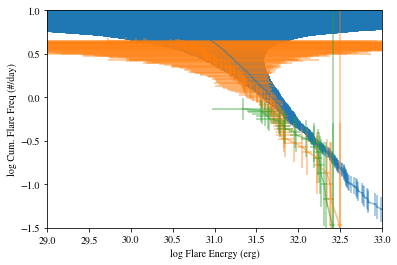

In [122]:
eye_sort = np.argsort(ed_eye)
energy_eye_sort = energy_eye[eye_sort]
sn_eye_sort = sn_eye[eye_sort]
x_vals_eye = energy_eye_sort
log_x_vals_eye = np.log10(x_vals_eye)
y_vals_eye = np.arange(0.001, len(energy_eye))[::-1]/30
log_y_vals_eye = np.log10(y_vals_eye)
log_x_err_eye = 1/np.log(10)/sn_eye_sort/np.log10(ed_eye[eye_sort])
_, perror = Perror(10**log_y_vals_eye*tess_time)/tess_time
log_y_err_eye = 1/np.log(10)*perror/y_vals_eye

ed_sort = np.argsort(ed)
energy_sort = energy[ed_sort]
sn_sort = sn[ed_sort]
x_vals = energy_sort
log_x_vals = np.log10(x_vals)
y_vals = np.arange(0.001, len(energy))[::-1]/30
log_y_vals = np.log10(y_vals)
log_x_err = 1/np.log(10)/sn_sort/np.log10(ed[ed_sort])
_, perror = Perror(10**log_y_vals*tess_time)/tess_time
log_y_err = 1/np.log(10)*perror/y_vals

plt.errorbar(kep_x, kep_y, xerr=kep_x_err, yerr=kep_y_err, alpha=0.5)
plt.errorbar(log_x_vals_eye, log_y_vals_eye, xerr=log_x_err_eye, yerr=log_y_err_eye, alpha=0.5)
plt.errorbar(log_x_vals, log_y_vals, xerr=log_x_err, yerr=log_y_err, alpha=0.5)
plt.xlim(29, 33)
plt.ylim(-1.5, 1)
plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Cum. Flare Freq (#/day)')

In [123]:
# Since the x values have errors on them, use ODR to fit a line to the log-log data
from scipy.odr import *

def f(B, x):
    return B[0]*x + B[1]

b00, b10 = -0.5, 10

linear = Model(f)
mydata = Data(log_x_vals, log_y_vals, wd=1/log_x_err**2, we=1/log_y_err**2)
myodr = ODR(mydata, linear, beta0=[b00, b10])
myoutput = myodr.run()
b0, b1 = myoutput.beta[0], myoutput.beta[1]
b0_err, b1_err = myoutput.sd_beta[0], myoutput.sd_beta[1]

mydata = Data(log_x_vals_eye, log_y_vals_eye, wd=1/log_x_err_eye**2, we=1/log_y_err_eye**2)
myodr = ODR(mydata, linear, beta0=[b00, b10])
myoutput = myodr.run()
b0_eye, b1_eye = myoutput.beta[0], myoutput.beta[1]
b0_err_eye, b1_err_eye = myoutput.sd_beta[0], myoutput.sd_beta[1]

mask = np.isfinite(kep_x)
mydata = Data(kep_x[mask], kep_y[mask], wd=1/kep_x_err[mask]**2, we=1/kep_y_err[mask]**2)
myodr = ODR(mydata, linear, beta0=[b00, b10])
myoutput = myodr.run()
b0_kep, b1_kep = myoutput.beta[0], myoutput.beta[1]
b0_err_kep, b1_err_kep = myoutput.sd_beta[0], myoutput.sd_beta[1]

print(str(b0) + ' +/- ' + str(b0_err))
print(str(b0_eye) + ' +/- ' + str(b0_err_eye))
print(str(b0_kep) + ' +/- ' + str(b0_err_kep))

-0.7410201296388456 +/- 0.06583263030648902
-1.044668704392609 +/- 0.02107395014439317
-0.9192477654296044 +/- 0.0016459448389900791


Text(0, 0.5, 'log Cum. Flare Freq (#/day)')

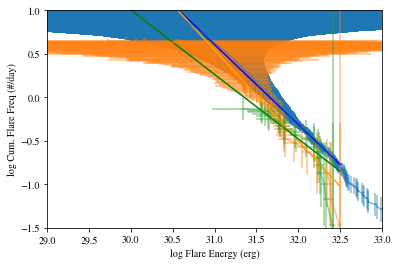

In [124]:
x_model = np.linspace(30, 32.5)
y_model = b0*x_model + b1
y_model_eye = b0_eye*x_model + b1_eye
y_model_kep = b0_kep*x_model + b1_kep

plt.errorbar(kep_x, kep_y, xerr=kep_x_err, yerr=kep_y_err, alpha=0.5)
plt.errorbar(log_x_vals_eye, log_y_vals_eye, xerr=log_x_err_eye, yerr=log_y_err_eye, alpha=0.5)
plt.errorbar(log_x_vals, log_y_vals, xerr=log_x_err, yerr=log_y_err, alpha=0.5)
plt.plot(x_model, y_model_kep, color='blue')
plt.plot(x_model, y_model_eye, color='orange')
plt.plot(x_model, y_model, color='green')
plt.xlim(29, 33)
plt.ylim(-1.5, 1)
plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Cum. Flare Freq (#/day)')

(-2, 1)

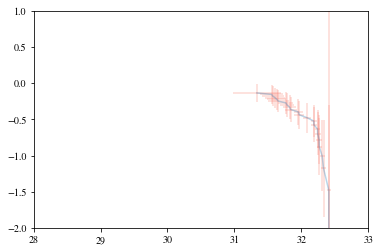

In [125]:
plt.errorbar(log_x_vals, log_y_vals, xerr=log_x_err, yerr=log_y_err, alpha=0.3, ecolor='salmon')
plt.xlim(28,33)
plt.ylim(-2, 1)

(-2, 1)

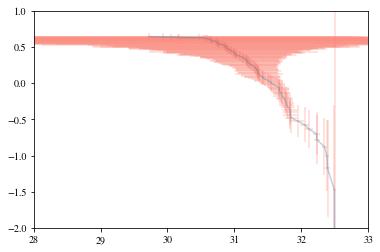

In [126]:
plt.errorbar(log_x_vals_eye, log_y_vals_eye, xerr=log_x_err_eye, yerr=log_y_err_eye, alpha=0.3, ecolor='salmon')
plt.xlim(28,33)
plt.ylim(-2, 1)

(-2, 1.5)

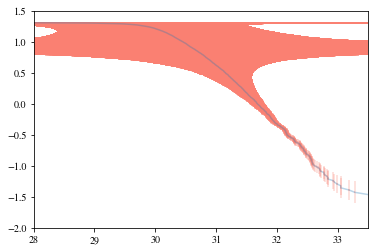

In [127]:
plt.errorbar(kep_x, kep_y, xerr=kep_x_err, yerr=kep_y_err, alpha=0.3, ecolor='salmon')
plt.xlim(28,33.5)
plt.ylim(-2,1.5)